# Índice

1. [Definición del *dataframe*](#data)
1. [Selección de modelos](#models)
   1. [Optimización de hiperparámetros: *Random Forest*](#hyperRF)
   1. [Optimización de hiperparámetros: *LightGBM*](#hyperXG)
1. [Cálculo del ITE](#ITE)

<a id='data'> </a>
# 1. Definición del *dataframe*

In [95]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn 

In [96]:
#Read main data to DataFrame
cleaned_df = pd.read_csv('processed_data/cleaned_df.csv', index_col=0)  

Se crea la partición *train-test* estratificando la sobre el outcome.

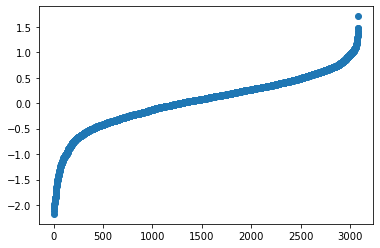

In [97]:
plt.scatter([i for i in range(len(cleaned_df["z_all_06"].sort_values().values))], cleaned_df["z_all_06"].sort_values().values)

(array([ 22.,  29.,  72., 165., 510., 906., 888., 397.,  90.,   6.]),
 array([-2.1753304 , -1.78710829, -1.39888618, -1.01066407, -0.62244196,
        -0.23421985,  0.15400226,  0.54222437,  0.93044648,  1.31866859,
         1.7068907 ]),
 <BarContainer object of 10 artists>)

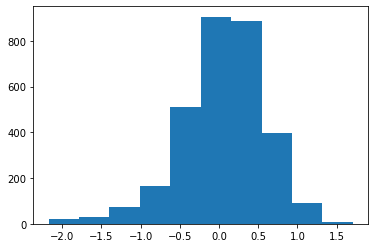

In [98]:
plt.hist(cleaned_df["z_all_06"])

In [99]:
cleaned_df["zall06_cat"] = pd.cut(cleaned_df["z_all_06"],
                               bins=[-np.inf, -0.75, -0.25, 0.25, 0.75, np.inf],
                               labels=[1, 2, 3, 4, 5])

In [100]:
cleaned_df["zall06_cat"].value_counts().sort_values()

5     202
1     203
2     567
4     941
3    1172
Name: zall06_cat, dtype: int64

In [101]:
treatment = 'tr'
outcome = 'z_all_06'
covariates = list(cleaned_df.columns)
covariates.remove(treatment)
covariates.remove(outcome)
covariates.remove("zall06_cat")

In [102]:
from sklearn.model_selection import train_test_split
# split data into train and test sets 
train, test = train_test_split(cleaned_df, stratify=cleaned_df.zall06_cat, test_size=0.2, random_state=42)

# set variables for causal forest Y=outcome, T=treatment, X=covariates, W=effect_modifiers 
y_train = train[outcome]
X_train = train[covariates+["tr"]]

X_test = test[covariates+["tr"]]
y_test =  test[outcome]

<a id='models'> </a>
# 2. Selección de modelos

Para el siguiente apartado probaremos los siguientes modelos: Linear Regression, Random Forest, y LightGBM. Empezamos con una versión "naïve" de los modelos, sin entrenar hiperparámetros.

In [103]:
def display_scores(scores,model_name = None):
    if(model_name):
        print("----",model_name,"----")
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [104]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

lgb_reg = lgb.LGBMRegressor(random_state=42)
lgb_reg.fit(X_train,y_train)

 
    # lets comare all of them 
models = [(lin_reg,"lin_reg"),
          (forest_reg,'Random Forest'),
          (lgb_reg,"XGboost")]
for model in models:
    scores = cross_val_score(model[0], X_test, y_test, scoring='r2', cv=10)
    display_scores(scores, model[1])
    scores = cross_val_score(model[0], X_test, y_test, scoring='neg_root_mean_squared_error', cv=10)
    display_scores(-scores, model[1])

---- lin_reg ----
Mean: 0.17930537796035112
Standard deviation: 0.08351243535261453
---- lin_reg ----
Mean: 0.46577149097717746
Standard deviation: 0.023835761775088338
---- Random Forest ----
Mean: 0.25823781939111756
Standard deviation: 0.10173596025100924
---- Random Forest ----
Mean: 0.4422920769846358
Standard deviation: 0.03189885507745995
---- XGboost ----
Mean: 0.24182023646279177
Standard deviation: 0.11936407830157791
---- XGboost ----
Mean: 0.44680751923337664
Standard deviation: 0.03596640175575824


In [105]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(clf, X_train, y_train, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=clf,
        X=X_train,
        y=y_train,
        cv=3,
        scoring="neg_root_mean_squared_error",
        train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    )

    train_mean = -train_scores.mean(axis=1)
    test_mean = -test_scores.mean(axis=1)

    plt.subplots(figsize=(5,4))
    plt.plot(train_sizes, train_mean, label="train")
    plt.plot(train_sizes, test_mean, label="validation")
    plt.ylim(0,0.55)

    plt.title("Learning Curve"+title)
    plt.xlabel("Training Set Size")
    plt.ylabel("RMSE")
    plt.legend(loc="best")
    
    plt.savefig('assets/results/LC'+title+'.png')

    plt.show()

## 2.A Optimización de hiperparámetros: _Random Forest_

Hacemos la optimización de hiperparámetros para los modelos de Random Forest y LightGBM (la regresión lineal no tiene parámetros). Comenzamos con el Random Forest.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 1000, cv = 3, verbose=-1,
                               random_state=42, n_jobs = 1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

In [106]:
base_model = RandomForestRegressor( random_state = 42)
scores = cross_val_score(base_model, X_train, y_train, scoring='r2', cv=10)
display_scores(scores, "Base RF (r2)")
scores = cross_val_score(base_model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
display_scores(-scores, "Base RF (rmse)")


#best_random = rf_random.best_estimator_
best_random=RandomForestRegressor(
    n_estimators= 144,
    min_samples_split= 10,
    min_samples_leaf= 2,
    max_features= 'sqrt',
    max_depth= 50,
    bootstrap= False)
scores = cross_val_score(best_random, X_train, y_train, scoring='r2', cv=10)
display_scores(scores, "Best random RF (r2)")
scores = cross_val_score(best_random, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
display_scores(-scores, "Best random RF (rmse)")

---- Base RF (r2) ----
Mean: 0.2956762685035671
Standard deviation: 0.03574761298115746
---- Base RF (rmse) ----
Mean: 0.4421178756637512
Standard deviation: 0.027888704712087195
---- Best random RF (r2) ----
Mean: 0.31461348811550616
Standard deviation: 0.04106892656060795
---- Best random RF (rmse) ----
Mean: 0.43543558733797133
Standard deviation: 0.02899952390490082


<a id="hyperXG"> </a>
## 2.B Optimización de hiperparámetros: *LightGBM*

In [ ]:
param_dist = {'boosting_type': ['gbdt', 'dart'],
                    'num_leaves': sp.stats.randint(2, 500),
                    'subsample_for_bin': sp.stats.randint(10, 1001),
                    'min_split_gain': sp.stats.uniform(0, 0.5),
                    'min_child_weight': sp.stats.uniform(1e-6, 1e-2),
                    'reg_alpha': sp.stats.uniform(0, 1e-2),
                    'reg_lambda': sp.stats.uniform(0, 1e-2),
                    'application': ['regression_l2'],
                    'subsample_freq': sp.stats.randint(1, 11),
                    'subsample': sp.stats.uniform(1e-3, 0.99),
                    'colsample_bytree': sp.stats.uniform(1e-3, 0.5),
                    'learning_rate': sp.stats.uniform(1e-6, 0.3),
                    'max_depth': sp.stats.randint(-1, 200),
                    'n_estimators': sp.stats.randint(100, 1000),
                    'extra_trees':[True]
                 }

In [ ]:
lgbm = lgb.LGBMRegressor(objective='regression', n_jobs=1)
rscv = RandomizedSearchCV(    estimator=lgbm,
                              param_distributions=param_dist,
                              cv=3,
                              n_iter=10000,
                              n_jobs=4,
                              verbose=1,
                              refit=True,
                            )
rscv = rscv.fit(X_train, y_train)

Los mejores parámetros para el LightGBM:

In [ ]:
rscv.best_params_

Luego, comparamos los resultados antes de la optimización de parámetros y después.

In [107]:
base_lightgbm =lgb.LGBMRegressor()
scores = cross_val_score(base_lightgbm, X_train, y_train, scoring='r2', cv=10)
display_scores(scores, "Base LightGBM (r2)")
scores = cross_val_score(base_lightgbm, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
display_scores(-scores, "Base LightGBM (rmse)")

#best_lightgbm= rscv.best_estimator_
best_lightgbm=lgb.LGBMRegressor(application= 'regression_l2',
     boosting_type= "gbdt",
     colsample_bytree= 0.38336326335596094,
     extra_trees= True,
     learning_rate= 0.17903385673674205,
     max_depth= 158,
     min_child_weight= 0.008879161272281614,
     min_split_gain= 0.1593340443302288,
     n_estimators= 473,
     num_leaves= 459,
     reg_alpha= 0.005018962703400557,
     reg_lambda= 0.002397730115616338,
     subsample= 0.9806477292744467,
     subsample_for_bin= 557,
     subsample_freq= 9)
scores = cross_val_score(best_lightgbm, X_train, y_train, scoring='r2', cv=10)
display_scores(scores, "Best random grid lightGBM (r2)")
scores = cross_val_score(best_lightgbm, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
display_scores(-scores, "Best random grid lightGBM (rmse)")

---- Base LightGBM (r2) ----
Mean: 0.2878115286446704
Standard deviation: 0.049437560346264724
---- Base LightGBM (rmse) ----
Mean: 0.4443225739508945
Standard deviation: 0.027791911362791067
---- Best random grid lightGBM (r2) ----
Mean: 0.32639376161946637
Standard deviation: 0.04374363047867577
---- Best random grid lightGBM (rmse) ----
Mean: 0.4324571435739125
Standard deviation: 0.03126098538328937


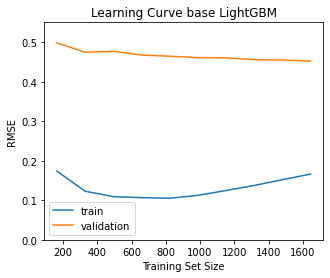

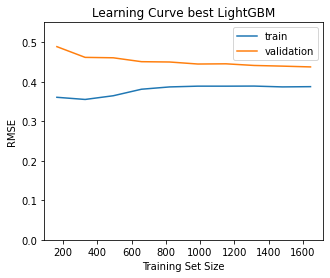

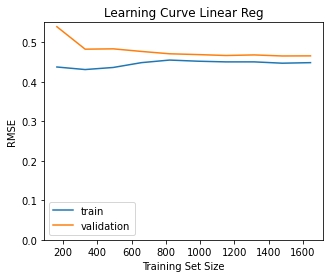

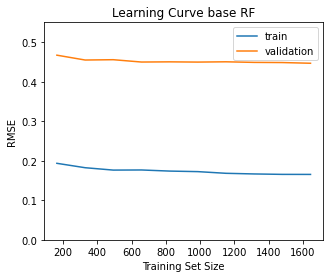

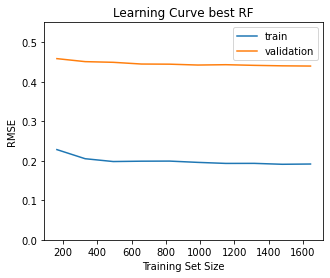

In [108]:
plot_learning_curve(base_lightgbm, X_train, y_train, " base LightGBM")
plot_learning_curve(best_lightgbm, X_train, y_train, " best LightGBM")
plot_learning_curve(lin_reg, X_train, y_train, " Linear Reg")
plot_learning_curve(base_model, X_train, y_train, " base RF")
plot_learning_curve(best_random, X_train, y_train, " best RF")

plt.show()

In [110]:
from scipy.interpolate import splprep, splev

def predict_subplot(clf, fila, col, train, tit):
    
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    clf.fit(X_train1, y_train1)
    
    if train=="train":
        y_pred=clf.predict(X_train1)
    else:
        y_pred=clf.predict(X_test1)
        
    predicted=pd.DataFrame(y_pred, columns=["y_pred"])
    if train=="train":
        predicted["y_true"]=y_train1.values
    else:
        predicted["y_true"]=y_test1.values
        
    predicted.sort_values(by="y_true", inplace=True)
    
    X=[i for i in range(len(y_pred))]
    y=predicted.y_pred
    
    #spline que interpola el nuvol X,y (y_pred)
    pts = np.vstack((X, y)) 
    (tck, u), fp, ier, msg = splprep(pts, u=None, per=0, k=3, full_output=True) 
    new_points = splev(u, tck)
    
    axs[fila,col].scatter(X, y, s=1)
    axs[fila,col].plot(new_points[0], new_points[1], 'b')
    axs[fila,col].scatter(X, predicted.y_true.values, s=1)
    axs[fila,col].set_title(tit)
    axs[fila,col].set_xlabel(None)
 

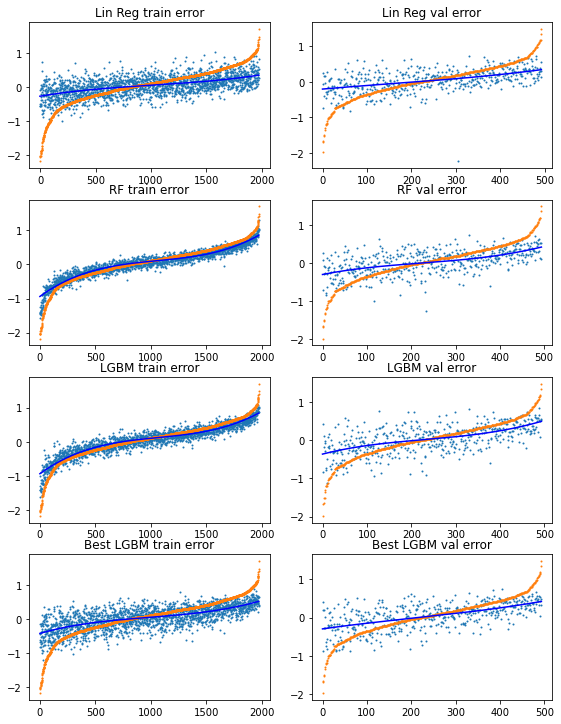

In [111]:
fig, axs = plt.subplots(4, 2,figsize=(8,10))
fig.tight_layout()

predict_subplot(lin_reg, 0, 0, "train", "Lin Reg train error")
predict_subplot(lin_reg, 0, 1, "test", "Lin Reg val error")

predict_subplot(base_model, 1, 0, "train", "RF train error")
predict_subplot(base_model, 1, 1, "test", "RF val error")

predict_subplot(base_lightgbm, 2, 0,"train", "LGBM train error")
predict_subplot(base_lightgbm, 2, 1,"test", "LGBM val error")

predict_subplot(best_lightgbm, 3, 0, "train", "Best LGBM train error")
predict_subplot(best_lightgbm, 3, 1, "test", "Best LGBM val error")

plt.savefig('assets/results/ScP_LinReg.png')
plt.show()

Conclusions BLALALBLA BLA escollim lightGBM BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB


BBBBBBBBBBBBBBBBBBBBBBBBBBBB

<AxesSubplot:>

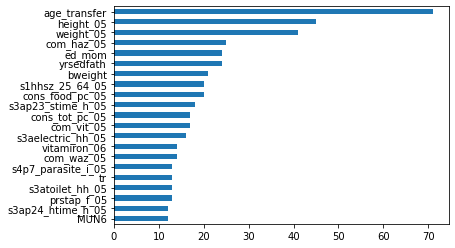

In [114]:
feature_importances=pd.Series(best_lightgbm.feature_importances_, index=X_train.columns).sort_values()
feature_importances[25:].plot(kind='barh')

In [115]:
from sklearn.metrics import mean_squared_error
y_pred=best_lightgbm.predict(X_test)
print(np.sqrt(mean_squared_error(y_pred, y_test)))

0.4294883169676213


Comentar que la metrica calculda es corresppon amb el valor estimat en les CV 



COMENTAR 








ADSFAGDASGNDJASGJKG

<a id="ITE"> </a>
# 3. Cálculo del ITE

Se crea el dataset correspondiente a los contrafactuales de nuestros datos.

In [122]:
counterfactual_df=cleaned_df.drop(["z_all_06", "zall06_cat"],axis=1)
a=counterfactual_df["tr"]+1
counterfactual_df["tr"]=a%2
counterfactual=best_lightgbm.predict(counterfactual_df)

In [123]:
observed=cleaned_df["z_all_06"]
counterfactuals=pd.Series(counterfactual, index=observed.index)

In [124]:
ite_temp=pd.Series([observed[i]-counterfactuals[i] for i in observed.index if cleaned_df.tr[i]==1]
                   , index=cleaned_df[cleaned_df.tr==1].index)
ite_temp1=pd.Series([counterfactuals[i]-observed[i] for i in observed.index if cleaned_df.tr[i]==0]
                    , index=cleaned_df[cleaned_df.tr==0].index)
ite=pd.concat([ite_temp,ite_temp1])
ite.sort_index(inplace=True)

In [125]:
ite.describe()

count    3085.000000
mean        0.068737
std         0.440692
min        -2.328430
25%        -0.194044
50%         0.099972
75%         0.359223
max         2.200828
dtype: float64

<AxesSubplot:ylabel='Count'>

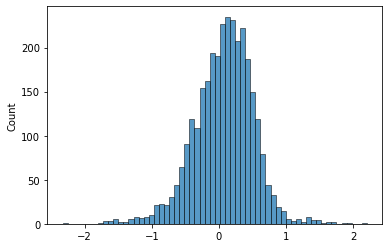

In [126]:
import seaborn as sb

sb.histplot(ite)

In [131]:
import os  
ite_df=cleaned_df[covariates+["tr"]].copy()
ite_df["ite"]=ite
ite_df.to_csv("processed_data/ite_df.csv")